In [84]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [85]:
# Set device (MPS or GPU if available)
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: mps


In [86]:
save_image = True

In [87]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 10
latent_dim = 2  # Reduce to 2 dimensions

In [ ]:
# MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        lambda x: x > 0,
        lambda x: x.float(),
    ]
)

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# VAE model
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Implements a Variational Autoencoder for unsupervised learning of latent representations.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.

    Attributes:
        fc1 (nn.Linear): First fully connected layer of the encoder.
        fc2 (nn.Linear): Second fully connected layer of the encoder.
        fc_mu (nn.Linear): Layer that outputs the mean of the latent Gaussian distribution.
        fc_logvar (nn.Linear): Layer that outputs the log variance of the latent Gaussian distribution.
        fc3 (nn.Linear): First fully connected layer of the decoder.
        fc4 (nn.Linear): Second fully connected layer of the decoder.
        relu (nn.ReLU): ReLU activation function.
        sigmoid (nn.Sigmoid): Sigmoid activation function.

    Methods:
        encode(x):
            Encodes input data into latent space.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

            Returns:
                Tuple[torch.Tensor, torch.Tensor]: Mean and log variance tensors of the latent distribution.

        reparameterize(mu, logvar):
            Samples from the latent space using the reparameterization trick.

            Args:
                mu (torch.Tensor): Mean tensor of the latent Gaussian distribution.
                logvar (torch.Tensor): Log variance tensor of the latent Gaussian distribution.

            Returns:
                torch.Tensor: Sampled latent vector.

        decode(z):
            Decodes latent vectors back to data space.

            Args:
                z (torch.Tensor): Latent tensor of shape (batch_size, latent_dim).

            Returns:
                torch.Tensor: Reconstructed input tensor.

        forward(x):
            Performs a forward pass through the VAE.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

            Returns:
                Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Reconstructed input, mean, and log variance tensors.
    """

    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        # Mean and log-variance for latent variables
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 512)
        self.fc5 = nn.Linear(512, 28 * 28)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        """
        Encodes input data into latent space.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and log variance tensors of the latent distribution.
        """
        # Encode input to latent space
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Samples from the latent space using the reparameterization trick.

        Args:
            mu (torch.Tensor): Mean tensor of the latent Gaussian distribution.
            logvar (torch.Tensor): Log variance tensor of the latent Gaussian distribution.

        Returns:
            torch.Tensor: Sampled latent vector.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        z = mu + eps * std
        return z

    def decode(self, z):
        """
        Decodes latent vectors back to data space.

        Args:
            z (torch.Tensor): Latent tensor of shape (batch_size, latent_dim).

        Returns:
            torch.Tensor: Reconstructed input tensor.
        """
        # Decode latent variable back to image
        h3 = self.relu(self.fc3(z))
        h4 = self.relu(self.fc4(h3))
        x_recon = self.sigmoid(self.fc5(h4))
        return x_recon

    def forward(self, x):
        """
        Performs a forward pass through the VAE.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Reconstructed input, mean, and log variance tensors.
        """
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [ ]:
# Loss function (combines reconstruction loss and KL divergence)
def loss_function(recon_x, x, mu, logvar):
    """
    Computes the VAE loss function as the sum of reconstruction loss and KL divergence.

    The loss function is defined as:
    Loss = Reconstruction Loss (BCE) + Kullback-Leibler Divergence (KLD)

    - **Reconstruction Loss (BCE):**
      Measures how well the decoder reconstructs the input data. It is computed using
      binary cross-entropy between the reconstructed output `recon_x` and the original input `x`.

    - **Kullback-Leibler Divergence (KLD):**
      Measures how much the learned latent distribution `q(z|x)` diverges from the prior distribution `p(z)`.
      For a VAE, it acts as a regularizer to ensure that the latent space follows a standard normal distribution.

    Args:
        recon_x (torch.Tensor): Reconstructed input of shape (batch_size, input_dim).
        x (torch.Tensor): Original input data of shape (batch_size, input_dim).
        mu (torch.Tensor): Mean of the latent Gaussian distribution (batch_size, latent_dim).
        logvar (torch.Tensor): Log variance of the latent Gaussian distribution (batch_size, latent_dim).

    Returns:
        torch.Tensor: Scalar loss value combining reconstruction loss and KL divergence.

    References:
        - Kingma, D. P., & Welling, M. (2014). **Auto-Encoding Variational Bayes**.
          *2nd International Conference on Learning Representations (ICLR)*.
    """
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28 * 28), reduction="sum"
    )
    # KL divergence between the learned latent distribution and standard normal distribution
    KLD = -0.5 * torch.sum(1.0 + logvar - mu.pow(2) - logvar.exp())
    # Total loss
    return BCE + KLD


In [91]:
# Initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [92]:
# Training loop
def train(epoch):
    """
    Train the VAE model for one epoch.

    Args:
        epoch (int): The current epoch number.

    Returns:
        None
    """
    model.train()

    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                "Epoch [{}/{}] Batch [{}/{}] Loss: {:.4f}".format(
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(train_loader),
                    loss.item() / len(data),
                )
            )

    average_loss = train_loss / len(train_loader.dataset)
    print("====> Epoch: {} Average loss: {:.4f}".format(epoch + 1, average_loss))


In [93]:
def test(epoch):
    """
    Evaluate the model on the test dataset.

    Args:
        epoch (int): The current epoch number.

    Returns:
        None
    """
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print("====> Test set loss: {:.4f}".format(test_loss))

In [94]:
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)

Epoch [1/10] Batch [0/469] Loss: 544.1063
Epoch [1/10] Batch [100/469] Loss: 214.4768
Epoch [1/10] Batch [200/469] Loss: 185.2153
Epoch [1/10] Batch [300/469] Loss: 185.2468
Epoch [1/10] Batch [400/469] Loss: 169.5854
====> Epoch: 1 Average loss: 194.6849
====> Test set loss: 169.5399
Epoch [2/10] Batch [0/469] Loss: 167.8914
Epoch [2/10] Batch [100/469] Loss: 166.3202
Epoch [2/10] Batch [200/469] Loss: 161.4999
Epoch [2/10] Batch [300/469] Loss: 159.7988
Epoch [2/10] Batch [400/469] Loss: 165.3420
====> Epoch: 2 Average loss: 165.8494
====> Test set loss: 161.9914
Epoch [3/10] Batch [0/469] Loss: 153.8926
Epoch [3/10] Batch [100/469] Loss: 164.2202
Epoch [3/10] Batch [200/469] Loss: 166.1309
Epoch [3/10] Batch [300/469] Loss: 161.2501
Epoch [3/10] Batch [400/469] Loss: 159.1883
====> Epoch: 3 Average loss: 160.2898
====> Test set loss: 157.6270
Epoch [4/10] Batch [0/469] Loss: 153.7171
Epoch [4/10] Batch [100/469] Loss: 155.9572
Epoch [4/10] Batch [200/469] Loss: 157.1651
Epoch [4/10]

In [ ]:
# Visualization of the latent space
model.eval()
with torch.no_grad():
    # Determine the total number of samples in the test dataset
    total_samples = len(test_loader.dataset)

    # Preallocate arrays for latent variables and labels
    z_all = np.zeros((total_samples, latent_dim), dtype=np.float32)
    labels_all = np.zeros(total_samples, dtype=np.int64)

    # Initialize starting index
    start_idx = 0

    for data, labels in test_loader:
        batch_size = data.size(0)
        data = data.to(device)
        data = data.view(-1, 28 * 28)
        # This modification ensures that each latent variable
        # z is a sample from the learned distribution
        # ( \mathcal{N}(\mu, \sigma^2) ), providing a
        # more faithful representation of the VAE's behavior.
        mu, logvar = model.encode(data)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        z = z.cpu().numpy()

        end_idx = start_idx + batch_size
        z_all[start_idx:end_idx] = z
        labels_all[start_idx:end_idx] = labels

        start_idx = end_idx


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_4232/71895262.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  labels_all[start_idx:end_idx] = labels


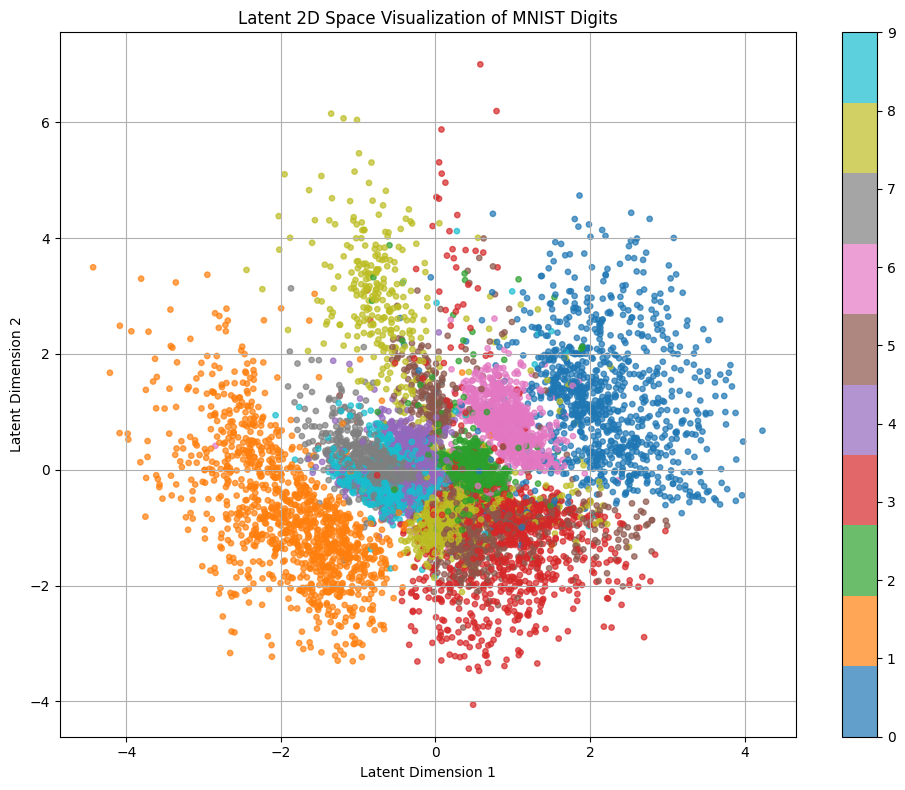

In [96]:
# Plot the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    z_all[:, 0], z_all[:, 1], c=labels_all, cmap="tab10", alpha=0.7, s=15
)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent 2D Space Visualization of MNIST Digits")
plt.grid(True)
plt.tight_layout()
if save_image:
    plt.savefig("results/latent_space.png", dpi=600)
plt.show()


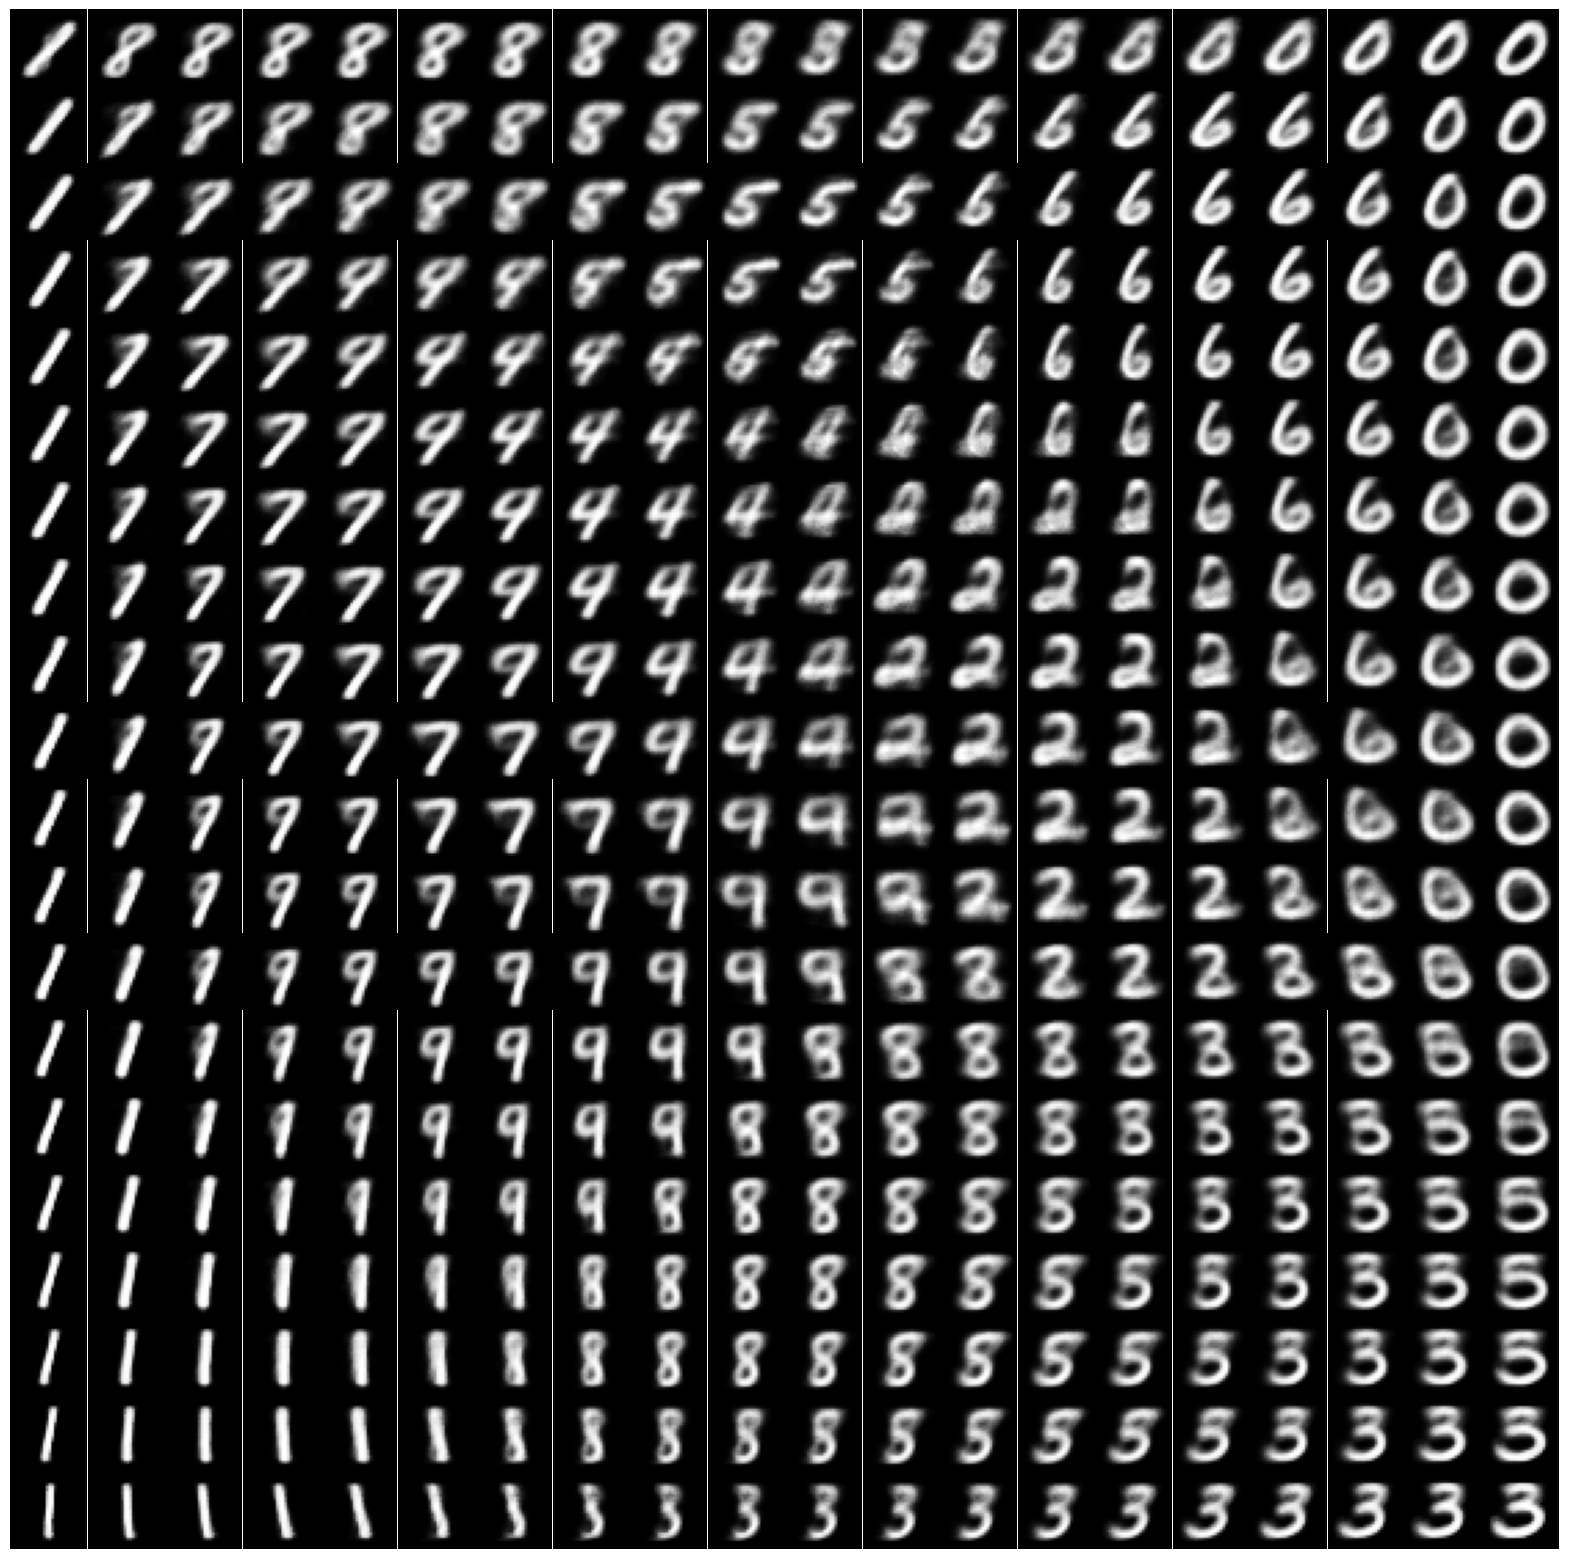

In [100]:
# Define the grid size
k = 20  # Number of points along each dimension

grid_x = torch.linspace(0.01, 0.99, k)
grid_y = torch.linspace(0.01, 0.99, k)
mesh_x, mesh_y = torch.meshgrid(
    grid_x, grid_y, indexing="xy"
)  # Ensure correct axis indexing

# Stack the grid coordinates into a shape (k*k, 2)
coords = torch.stack([mesh_x, mesh_y], dim=-1).view(-1, 2)

# Map the uniformly distributed samples to the standard normal distribution using the inverse CDF
normal = torch.distributions.normal.Normal(0, 1)
z = normal.icdf(coords)  # Shape: (k*k, 2)

# Move the model to evaluation mode
model.eval()

# Move the grid points to the same device as the model
z = z.to(device)

with torch.no_grad():
    # Decode the latent variables to generate images
    reconstructed = model.decode(z).cpu()  # Shape: (k*k, 28*28)

# Reshape the reconstructed images for visualization
images = reconstructed.view(-1, 1, 28, 28)  # Shape: (k*k, 1, 28, 28)

# Convert images to NumPy array for plotting
images = images.numpy()

# Create a figure with a grid of subplots
fig, axes = plt.subplots(k, k, figsize=(k, k))

for i in range(k):
    for j in range(k):
        idx = i * k + j  # Index of the current image
        # Reverse the order of rows to have the lowest latent y-values at the bottom
        ax = axes[k - i - 1, j]
        ax.imshow(images[idx, 0, :, :], cmap="gray")
        ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0)
if save_image:
    plt.savefig("results/generated_digits.png", dpi=600)
plt.show()

Certainly! Here are some additional suggestions to improve your notebook:

1. **Implement a Learning Rate Scheduler**

   - **Why:** Adjusting the learning rate during training can help the model converge more efficiently.
   - **How:** Use PyTorch's learning rate scheduler to reduce the learning rate at certain epochs.
   - **Code Example:**

     ```python
     from torch.optim.lr_scheduler import StepLR

     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

     for epoch in range(num_epochs):
         for data, _ in train_loader:
             # Training steps...
             optimizer.zero_grad()
             loss.backward()
             optimizer.step()
         scheduler.step()
     ```

2. **Use Convolutional Layers for Image Data**

   - **Why:** Images have spatial hierarchies that convolutional neural networks (CNNs) can capture more effectively than fully connected layers.
   - **How:** Replace the linear layers in your encoder and decoder with convolutional and transposed convolutional layers.
   - **Code Example:**

     ```python
     class ConvVAE(nn.Module):
         def __init__(self):
             super(ConvVAE, self).__init__()
             # Encoder
             self.enc_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
             self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
             self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
             self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
             # Decoder
             self.dec_fc = nn.Linear(latent_dim, 64 * 7 * 7)
             self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
             self.dec_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

         def encode(self, x):
             h = F.relu(self.enc_conv1(x))
             h = F.relu(self.enc_conv2(h))
             h = h.view(-1, 64 * 7 * 7)
             mu = self.fc_mu(h)
             logvar = self.fc_logvar(h)
             return mu, logvar

         def decode(self, z):
             h = F.relu(self.dec_fc(z))
             h = h.view(-1, 64, 7, 7)
             h = F.relu(self.dec_conv1(h))
             h = torch.sigmoid(self.dec_conv2(h))
             return h

         def reparameterize(self, mu, logvar):
             std = torch.exp(0.5 * logvar)
             eps = torch.randn_like(std)
             return mu + eps * std

         def forward(self, x):
             mu, logvar = self.encode(x)
             z = self.reparameterize(mu, logvar)
             return self.decode(z), mu, logvar
     ```

3. **Implement Data Augmentation**

   - **Why:** Augmenting your data can improve the robustness and generalization of your model.
   - **How:** Use `torchvision.transforms` to apply random transformations to your dataset.
   - **Code Example:**

     ```python
     from torchvision import datasets, transforms

     transform = transforms.Compose([
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(10),
         transforms.ToTensor()
     ])

     train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
     ```

4. **Incorporate Batch Normalization and Dropout**

   - **Why:** Batch normalization speeds up training and improves stability; dropout helps prevent overfitting.
   - **How:** Add `nn.BatchNorm1d` or `nn.BatchNorm2d` after layers and `nn.Dropout` before activation functions.
   - **Code Example:**

     ```python
     self.fc1 = nn.Sequential(
         nn.Linear(input_dim, hidden_dim),
         nn.BatchNorm1d(hidden_dim),
         nn.ReLU(),
         nn.Dropout(p=0.5)
     )
     ```

5. **Adjust the Loss Function with a Beta Parameter**

   - **Why:** Balancing the reconstruction loss and the KL divergence term can lead to better latent representations.
   - **How:** Introduce a `beta` parameter to weight the KL divergence.
   - **Code Example:**

     ```python
     def loss_function(recon_x, x, mu, logvar, beta=1.0):
         BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
         KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
         return BCE + beta * KLD
     ```

6. **Use TensorBoard for Monitoring**

   - **Why:** Visualizing training metrics can help you understand and debug the training process.
   - **How:** Integrate TensorBoard to log losses and other metrics.
   - **Code Example:**

     ```python
     from torch.utils.tensorboard import SummaryWriter

     writer = SummaryWriter()

     for epoch in range(num_epochs):
         for data, _ in train_loader:
             # Training steps...
             writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)
     writer.close()
     ```

7. **Visualize the Latent Space with t-SNE or PCA**

   - **Why:** Advanced dimensionality reduction techniques can provide better insights into the latent space structure.
   - **How:** Use scikit-learn's `TSNE` or `PCA` to reduce the latent dimensions to 2D for visualization.
   - **Code Example:**

     ```python
     from sklearn.manifold import TSNE
     import matplotlib.pyplot as plt

     tsne = TSNE(n_components=2)
     z_tsne = tsne.fit_transform(z_all)

     plt.figure(figsize=(8, 6))
     plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels_all, cmap='tab10')
     plt.colorbar()
     plt.show()
     ```

8. **Hyperparameter Tuning with Optuna**

   - **Why:** Systematic hyperparameter optimization can significantly improve model performance.
   - **How:** Use Optuna to automate the tuning process.
   - **Code Example:**

     ```python
     import optuna

     def objective(trial):
         # Suggest values for hyperparameters
         lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
         beta = trial.suggest_uniform('beta', 0.1, 5.0)
         # Define model, optimizer, and loss function
         # Training loop...
         # Return validation loss
         return val_loss

     study = optuna.create_study(direction='minimize')
     study.optimize(objective, n_trials=50)
     ```

9. **Implement Model Checkpointing**

   - **Why:** Saving model states allows you to resume training and keeps the best-performing models.
   - **How:** Save the model state dict when validation loss decreases.
   - **Code Example:**

     ```python
     best_val_loss = float('inf')
     for epoch in range(num_epochs):
         # Training and validation loops...
         if val_loss < best_val_loss:
             best_val_loss = val_loss
             torch.save(model.state_dict(), 'best_vae_model.pth')
     ```

10. **Set Random Seeds for Reproducibility**

    - **Why:** Ensures that your experiments are reproducible.
    - **How:** Set seeds for `torch`, `numpy`, and `random`.
    - **Code Example:**

      ```python
      import torch
      import numpy as np
      import random

      seed = 42
      torch.manual_seed(seed)
      np.random.seed(seed)
      random.seed(seed)
      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      ```

11. **Structure Code into Modular Functions**

    - **Why:** Improves readability and maintainability.
    - **How:** Encapsulate repetitive code into functions (e.g., training loop, validation loop).
    - **Code Example:**

      ```python
      def train_epoch(model, dataloader, optimizer):
          model.train()
          train_loss = 0
          for data, _ in dataloader:
              # Training steps...
          return train_loss / len(dataloader.dataset)
      ```

12. **Add Detailed Comments and Docstrings**

    - **Why:** Helps others understand your code and assists in future maintenance.
    - **How:** Use descriptive comments and docstrings for functions and classes.
    - **Example:**

      ```python
      def reparameterize(self, mu, logvar):
          """
          Reparameterization trick to sample from N(mu, var) from N(0,1).

          Args:
              mu (Tensor): Mean of the latent Gaussian.
              logvar (Tensor): Log variance of the latent Gaussian.

          Returns:
              Tensor: Sampled latent vector.
          """
          std = torch.exp(0.5 * logvar)
          eps = torch.randn_like(std)
          return mu + eps * std
      ```

13. **Implement Error Handling**

    - **Why:** Makes your code more robust and easier to debug.
    - **How:** Use try-except blocks around critical operations.
    - **Code Example:**

      ```python
      try:
          # Critical code segment
          output = model(input_data)
      except Exception as e:
          print(f"An error occurred: {e}")
      ```

14. **Optimize Data Loading with `num_workers`**

    - **Why:** Increases data loading speed by using multiple subprocesses.
    - **How:** Set `num_workers` in your DataLoader based on your CPU cores.
    - **Code Example:**

      ```python
      import multiprocessing

      num_workers = multiprocessing.cpu_count()

      train_loader = DataLoader(
          train_dataset,
          batch_size=batch_size,
          shuffle=True,
          pin_memory=True,
          num_workers=num_workers
      )
      ```

15. **Monitor GPU and CPU Usage**

    - **Why:** Ensures efficient resource utilization and helps prevent bottlenecks.
    - **How:** Use monitoring tools like `nvidia-smi` for GPUs and `htop` or `top` for CPUs.

16. **Initialize Weights Properly**

    - **Why:** Proper weight initialization can speed up convergence.
    - **How:** Apply initialization methods like Xavier (Glorot) or He initialization.
    - **Code Example:**

      ```python
      def init_weights(m):
          if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
              nn.init.xavier_uniform_(m.weight)
              if m.bias is not None:
                  nn.init.zeros_(m.bias)

      model.apply(init_weights)
      ```

17. **Normalize Input Data**

    - **Why:** Normalization can lead to better convergence and model performance.
    - **How:** Apply normalization transforms based on your dataset statistics.
    - **Code Example:**

      ```python
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
      ])
      ```

18. **Visualize Reconstructions**

    - **Why:** Visual inspection helps you qualitatively assess model performance.
    - **How:** Compare original and reconstructed images side by side.
    - **Code Example:**

      ```python
      import matplotlib.pyplot as plt

      model.eval()
      with torch.no_grad():
          data, _ = next(iter(test_loader))
          data = data.to(device)
          recon, _, _ = model(data)
          recon = recon.cpu()
          data = data.cpu()

          fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))
          for i in range(6):
              axes[0, i].imshow(data[i].view(28, 28), cmap='gray')
              axes[0, i].axis('off')
              axes[1, i].imshow(recon[i].view(28, 28), cmap='gray')
              axes[1, i].axis('off')
          plt.show()
      ```

19. **Update to the Latest PyTorch Version**

    - **Why:** Benefit from performance improvements and new features.
    - **How:** Upgrade PyTorch and modify code if necessary.

20. **Experiment with Different Variants of VAEs**

    - **Why:** Certain VAE variants may provide better results for your specific use case.
    - **How:** Try Conditional VAEs, Beta-VAEs, or Vector Quantized VAEs.

By applying these suggestions, you can enhance the performance, efficiency, and clarity of your notebook. This will not only improve your current project but also provide you with a stronger foundation for future deep learning tasks.